In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [2]:
df_T=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Temperature_Value.csv', sep=';')
df_stir=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Stirrer_Value.csv', sep=';')
df_feed1=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Feed 1_Value.csv', sep=';')
#df_feed2=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Feed 2_Value.csv', sep=';')
#df_pumpfeed1=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Feed 1_Value.csv', sep=';')
#df_pumpfeed2=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Feed 2_Value.csv', sep=';')
df_base=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Base_Value.csv', sep=';')
#df_antifoam=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Antifoam_Value.csv', sep=';')
df_acid=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Acid_Value.csv', sep=';')
df_pO2=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pO₂_Value.csv', sep=';')
df_pH=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pH_Value.csv', sep=';')
#df_CO2=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Flow - CO₂_Value.csv', sep=';')
df_air=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Flow - Air_Value.csv', sep=';')
#df_level=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Levelsensor_Value.csv', sep=';')
df_offgas=pd.read_excel('fermentation raw data/offgas_data.xlsx')

In [3]:
parameters_df=[df_T, df_stir, df_feed1, df_base, df_acid, df_pO2, df_pH, df_air]

In [4]:
start = '31-05-2023 10:14:00'
end = '02-06-2023 08:22:00'
start_time = datetime.strptime(start, '%d-%m-%Y %H:%M:%S')
end_time = datetime.strptime(end, '%d-%m-%Y %H:%M:%S')

In [5]:
df_merged=pd.DataFrame()
for df in parameters_df:
    df_copy=df.copy()
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')
    df_grouped=df_copy.groupby(df_copy['DateTime'].dt.strftime('%Y-%m-%dT%H:%M')).first()
    df_grouped['strings']=df_grouped['DateTime'].dt.strftime("%Y-%m-%d %H:%M")+ ':00'
    df_grouped['DateTime']=pd.to_datetime(df_grouped['strings'], format='%Y-%m-%d %H:%M:%S')
    df_grouped.drop(['Date', 'Time', 'strings'], axis=1, inplace=True)
    df_grouped[df_grouped.columns[1]]=df_grouped[df_grouped.columns[1]].str.replace(',', '.')
    df_grouped[df_grouped.columns[1]]=pd.to_numeric(df_grouped[df_grouped.columns[1]], errors='coerce')
    df_se=df_grouped[(df_grouped['DateTime'] > start_time) & (df_grouped['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged.empty:
        df_merged=df_se
    else:
        df_merged=df_merged.merge(df_se, on='DateTime', how='inner')

In [6]:
df_off_grouped=df_offgas.groupby(df_offgas['Timestamp'].dt.strftime('%Y-%m-%dT%H:%M')).first()
df_off_grouped.reset_index(drop=True, inplace=True)
df_off_grouped['strings']=df_off_grouped['Timestamp'].dt.strftime("%Y-%m-%d %H:%M")+ ':00'
df_off_grouped['DateTime']=pd.to_datetime(df_off_grouped['strings'], format='%Y-%m-%d %H:%M:%S')
df_off_grouped.drop(['Timestamp', 'strings'], axis=1, inplace=True)
df_off_grouped=df_off_grouped[(df_off_grouped['DateTime'] > start_time) & (df_off_grouped['DateTime'] < end_time)]
df_off_grouped.shape

(2767, 7)

In [7]:
total_df=df_merged.merge(df_off_grouped, on='DateTime', how='inner')
df_filter=total_df.drop(['offg_ethanol', 'offg_methanol', 'offg_RMS'], axis=1, inplace=False)
first_timestamp = df_filter['DateTime'].iloc[0]  # Get the first timestamp
df_filter['time [h]'] = (df_filter['DateTime'] - first_timestamp) / pd.Timedelta(hours=1)
df_filter['time [h]']=df_filter['time [h]'].round(2)
df_filter.head(3)

,DateTime,Temperature Value (°C),Stirrer Value (rpm),Feed 1 Value (%),Pump - Base Value (%),Pump - Acid Value (%),pO₂ Value (pO₂),pH Value (pH),Flow - Air Value,offg_co2,offg_n2,offg_o2,time [h]
0,2023-05-31 10:15:00,29.88,295.08,0.0,0.0,0.0,77.91,7.03,1.0,0.039013,77.502221,21.178293,0.00
1,2023-05-31 10:16:00,29.85,292.41,0.0,0.0,0.0,66.31,7.02,1.0,0.039162,77.492184,21.179474,0.02
2,2023-05-31 10:17:00,29.87,296.30,0.0,0.0,0.0,64.32,7.02,1.0,0.039200,77.505519,21.176716,0.03


In [8]:
df_biomass=pd.read_csv('fermentation raw data/biomass.csv', sep=';')
for col in df_biomass.columns:
    df_biomass[col]=df_biomass[col].str.replace(',', '.')
    df_biomass[col]=pd.to_numeric(df_biomass[col])
df_biomass.rename(columns={'duration [h]': 'time [h]', 'biomass (g/L)': 'Biomass [g/L]'}, inplace=True)
df_biomass.head(3)

,Biomass [g/L],time [h]
0,0.694,0.2
1,1.311,2.1
2,1.542,2.3


In [9]:
df_included = df_filter.merge(df_biomass, on='time [h]', how='left')
df_included['Biomass [g/L]']=df_included['Biomass [g/L]'].replace('', np.nan)
df_included.head(3)

,DateTime,Temperature Value (°C),Stirrer Value (rpm),Feed 1 Value (%),Pump - Base Value (%),Pump - Acid Value (%),pO₂ Value (pO₂),pH Value (pH),Flow - Air Value,offg_co2,offg_n2,offg_o2,time [h],Biomass [g/L]
0,2023-05-31 10:15:00,29.88,295.08,0.0,0.0,0.0,77.91,7.03,1.0,0.039013,77.502221,21.178293,0.00,NaN
1,2023-05-31 10:16:00,29.85,292.41,0.0,0.0,0.0,66.31,7.02,1.0,0.039162,77.492184,21.179474,0.02,NaN
2,2023-05-31 10:17:00,29.87,296.30,0.0,0.0,0.0,64.32,7.02,1.0,0.039200,77.505519,21.176716,0.03,NaN


In [10]:
# the peak around the 7th hour was not fed into the batch but just to accumulate the glucose in the pipe
df_included.loc[df_included['Feed 1 Value (%)'] == float(80), 'Feed 1 Value (%)'] = 0

In [11]:
# after 35 h the Glucose feed was empty but it was still measured as feeding
df_included.loc[df_included['time [h]'] > 35, 'Feed 1 Value (%)'] = 0
df_included['Feed 1 Value (%)']=df_included['Feed 1 Value (%)']/(10*1000)
df_included.rename(columns={'Feed 1 Value (%)': 'Glucose feed [L/min]'}, inplace=True)

In [12]:
df_included['Pump - Base Value (%)']=df_included['Pump - Base Value (%)']/(12*10*1000)
df_included['Pump - Acid Value (%)']=df_included['Pump - Acid Value (%)']/(12*10*1000)
df_included.rename(columns={'Pump - Base Value (%)': 'Pump - Base [L/min]', 'Pump - Acid Value (%)': 'Pump - Acid [L/min]'}, inplace=True)

In [13]:
df_included['cum. base feed [ml/min]']=df_included['Pump - Base [L/min]'].cumsum()
df_included['cum. acid feed [ml/min]']=df_included['Pump - Acid [L/min]'].cumsum()

In [14]:
df_included.columns

Index(['DateTime', 'Temperature Value (°C)', 'Stirrer Value (rpm)',
       'Glucose feed [L/min]', 'Pump - Base [L/min]', 'Pump - Acid [L/min]',
       'pO₂ Value (pO₂)', 'pH Value (pH)', 'Flow - Air Value', 'offg_co2',
       'offg_n2', 'offg_o2', 'time [h]', 'Biomass [g/L]',
       'cum. base feed [ml/min]', 'cum. acid feed [ml/min]'],
      dtype='object')

In [15]:
df_included['Volume [L]']=df_included['Glucose feed [L/min]']+df_included['Pump - Base [L/min]']+df_included['Pump - Acid [L/min]']
df_included['Volume [L]']=df_included['Volume [L]'].cumsum().add(1)
df_included['Glucose feed [g/h]']=df_included['Glucose feed [L/min]']*350*60
df_included['DO2 - smoothed']=df_included['pO₂ Value (pO₂)'].ewm(alpha=0.1).mean()
df_included['Stirring [rpm]- smoothed']=df_included['Stirrer Value (rpm)'].ewm(alpha=0.1).mean()
df_included['T [°C]- smoothed']=df_included['Temperature Value (°C)'].ewm(alpha=0.1).mean()
df_included.head()

,DateTime,Temperature Value (°C),Stirrer Value (rpm),Glucose feed [L/min],Pump - Base [L/min],Pump - Acid [L/min],pO₂ Value (pO₂),pH Value (pH),Flow - Air Value,offg_co2,...,offg_o2,time [h],Biomass [g/L],cum. base feed [ml/min],cum. acid feed [ml/min],Volume [L],Glucose feed [g/h],DO2 - smoothed,Stirring [rpm]- smoothed,T [°C]- smoothed
0,2023-05-31 10:15:00,29.88,295.08,0.0,0.0,0.0,77.91,7.03,1.0,0.039013,...,21.178293,0.00,NaN,0.0,0.0,1.0,0.0,77.910000,295.080000,29.880000
1,2023-05-31 10:16:00,29.85,292.41,0.0,0.0,0.0,66.31,7.02,1.0,0.039162,...,21.179474,0.02,NaN,0.0,0.0,1.0,0.0,71.804737,293.674737,29.864211
2,2023-05-31 10:17:00,29.87,296.30,0.0,0.0,0.0,64.32,7.02,1.0,0.039200,...,21.176716,0.03,NaN,0.0,0.0,1.0,0.0,69.042841,294.643469,29.866347
3,2023-05-31 10:18:00,29.77,293.57,0.0,0.0,0.0,53.72,7.01,1.0,0.039410,...,21.172557,0.05,NaN,0.0,0.0,1.0,0.0,64.587232,294.331323,29.838331
4,2023-05-31 10:19:00,29.76,291.77,0.0,0.0,0.0,52.38,7.01,1.0,0.040346,...,21.173347,0.07,NaN,0.0,0.0,1.0,0.0,61.606296,293.705863,29.819203


In [16]:
df_included['Volume [L]'].max()

2.4112694999999964

In [17]:
df_included.rename(columns={'Temperature Value (°C)': 'Temperature [°C]', 'Stirrer Value (rpm)': 'Stirrer [rpm]'}, errors='raise', inplace=True)
df_included.rename(columns={'offg_co2': 'Offgas CO2 [%]', 'offg_n2': 'Offgas N2 [%]', 'offg_o2': 'Offgas O2 [%]'}, inplace=True)
df_included.head()

,DateTime,Temperature [°C],Stirrer [rpm],Glucose feed [L/min],Pump - Base [L/min],Pump - Acid [L/min],pO₂ Value (pO₂),pH Value (pH),Flow - Air Value,Offgas CO2 [%],...,Offgas O2 [%],time [h],Biomass [g/L],cum. base feed [ml/min],cum. acid feed [ml/min],Volume [L],Glucose feed [g/h],DO2 - smoothed,Stirring [rpm]- smoothed,T [°C]- smoothed
0,2023-05-31 10:15:00,29.88,295.08,0.0,0.0,0.0,77.91,7.03,1.0,0.039013,...,21.178293,0.00,NaN,0.0,0.0,1.0,0.0,77.910000,295.080000,29.880000
1,2023-05-31 10:16:00,29.85,292.41,0.0,0.0,0.0,66.31,7.02,1.0,0.039162,...,21.179474,0.02,NaN,0.0,0.0,1.0,0.0,71.804737,293.674737,29.864211
2,2023-05-31 10:17:00,29.87,296.30,0.0,0.0,0.0,64.32,7.02,1.0,0.039200,...,21.176716,0.03,NaN,0.0,0.0,1.0,0.0,69.042841,294.643469,29.866347
3,2023-05-31 10:18:00,29.77,293.57,0.0,0.0,0.0,53.72,7.01,1.0,0.039410,...,21.172557,0.05,NaN,0.0,0.0,1.0,0.0,64.587232,294.331323,29.838331
4,2023-05-31 10:19:00,29.76,291.77,0.0,0.0,0.0,52.38,7.01,1.0,0.040346,...,21.173347,0.07,NaN,0.0,0.0,1.0,0.0,61.606296,293.705863,29.819203


In [18]:
df_included.sort_index(axis=1, inplace=True)
df_included.head(3)

,Biomass [g/L],DO2 - smoothed,DateTime,Flow - Air Value,Glucose feed [L/min],Glucose feed [g/h],Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],Pump - Acid [L/min],...,Stirrer [rpm],Stirring [rpm]- smoothed,T [°C]- smoothed,Temperature [°C],Volume [L],cum. acid feed [ml/min],cum. base feed [ml/min],pH Value (pH),pO₂ Value (pO₂),time [h]
0,NaN,77.910000,2023-05-31 10:15:00,1.0,0.0,0.0,0.039013,77.502221,21.178293,0.0,...,295.08,295.080000,29.880000,29.88,1.0,0.0,0.0,7.03,77.91,0.00
1,NaN,71.804737,2023-05-31 10:16:00,1.0,0.0,0.0,0.039162,77.492184,21.179474,0.0,...,292.41,293.674737,29.864211,29.85,1.0,0.0,0.0,7.02,66.31,0.02
2,NaN,69.042841,2023-05-31 10:17:00,1.0,0.0,0.0,0.039200,77.505519,21.176716,0.0,...,296.30,294.643469,29.866347,29.87,1.0,0.0,0.0,7.02,64.32,0.03


In [19]:
df_included.to_csv('fermentation raw data/data_combined.csv')
df_included.to_excel('fermentation raw data/data_combined.xlsx')

In [20]:
df_included.columns

Index(['Biomass [g/L]', 'DO2 - smoothed', 'DateTime', 'Flow - Air Value',
       'Glucose feed [L/min]', 'Glucose feed [g/h]', 'Offgas CO2 [%]',
       'Offgas N2 [%]', 'Offgas O2 [%]', 'Pump - Acid [L/min]',
       'Pump - Base [L/min]', 'Stirrer [rpm]', 'Stirring [rpm]- smoothed',
       'T [°C]- smoothed', 'Temperature [°C]', 'Volume [L]',
       'cum. acid feed [ml/min]', 'cum. base feed [ml/min]', 'pH Value (pH)',
       'pO₂ Value (pO₂)', 'time [h]'],
      dtype='object')

C:\Users\Deborah\AppData\Local\Temp\ipykernel_9820\2446654563.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap1 = plt.cm.get_cmap('Set1')


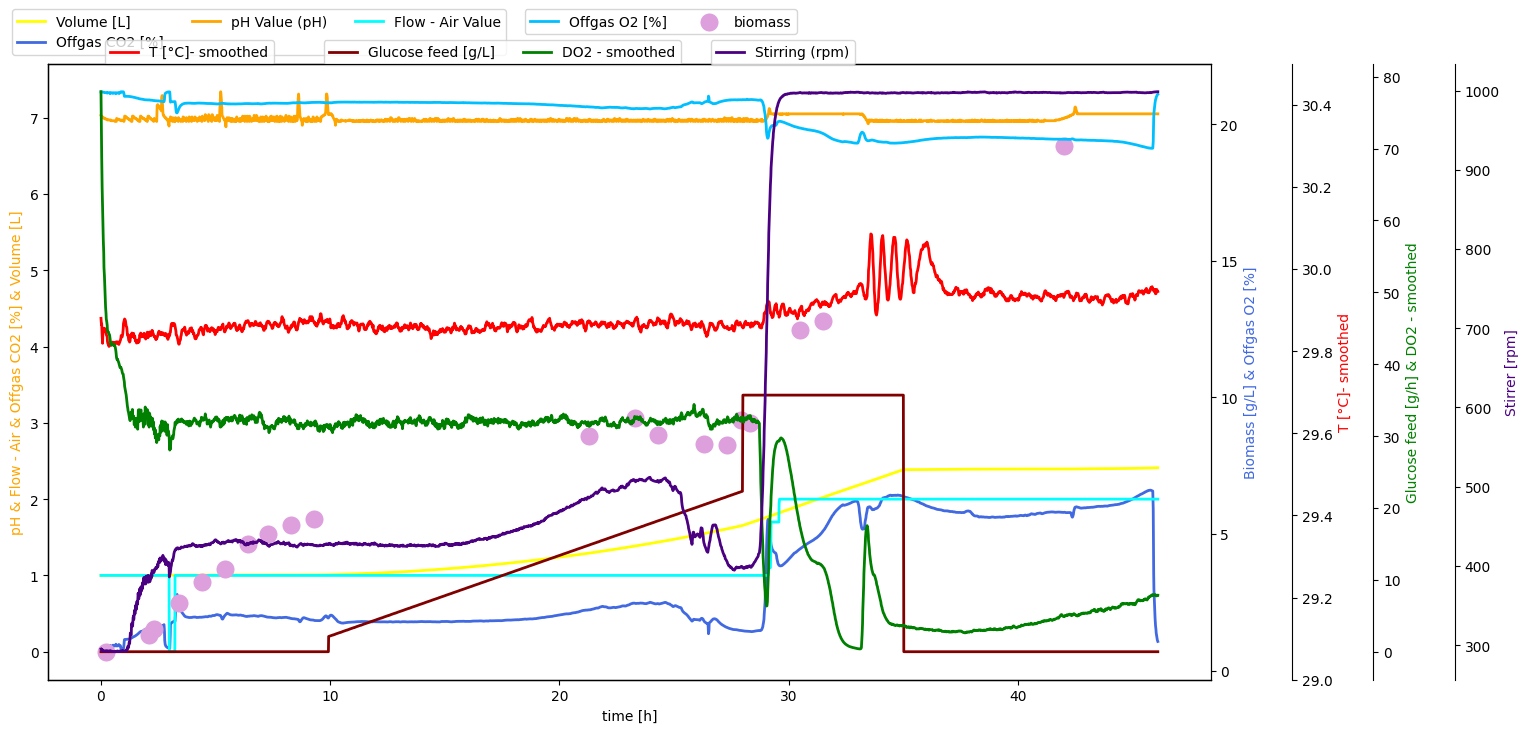

In [21]:
fig, ax = plt.subplots(1,1,figsize=(15,8))

colormap1 = plt.cm.get_cmap('Set1')

ax_sec=ax.twinx()
ax_third=ax.twinx()
ax_4th=ax.twinx()
ax_5th=ax.twinx()
ax_5th.plot(df_included['time [h]'], df_included['Stirring [rpm]- smoothed'], label='Stirring (rpm)', color='indigo', linewidth=2)

ax_4th.plot(df_included['time [h]'], df_included['Glucose feed [g/h]'], label='Glucose feed [g/L]', color='maroon', linewidth=2)
ax_4th.plot(df_included['time [h]'], df_included['DO2 - smoothed'], label='DO2 - smoothed', color='green', linewidth=2)

ax_third.plot(df_included['time [h]'], df_included['T [°C]- smoothed'], label='T [°C]- smoothed', color='red', linewidth=2)
ax_third.set_ylim(29,30.5)

ax_sec.plot(df_included['time [h]'], df_included['Offgas O2 [%]'], label='Offgas O2 [%]', color='deepskyblue', linewidth=2)

ax.plot(df_included['time [h]'], df_included['Volume [L]'], label='Volume [L]', color='yellow', linewidth=2)
ax.plot(df_included['time [h]'], df_included['Offgas CO2 [%]'], label='Offgas CO2 [%]', color='royalblue', linewidth=2)
ax.plot(df_included['time [h]'], df_included['pH Value (pH)'], label='pH Value (pH)', color='orange', linewidth=2)
ax.plot(df_included['time [h]'], df_included['Flow - Air Value'], label='Flow - Air Value', color='aqua', linewidth=2)

ax_sec.scatter(df_included['time [h]'], df_included['Biomass [g/L]'], linewidth=7, color='plum', label='biomass')

ax_third.spines.right.set_position(("axes", 1.07))
ax_4th.spines.right.set_position(("axes", 1.14))
ax_5th.spines.right.set_position(("axes", 1.21))

ax.set_xlabel('time [h]')
ax.set_ylabel('pH & Flow - Air & Offgas CO2 [%] & Volume [L]', color='orange')
ax_sec.set_ylabel('Biomass [g/L] & Offgas O2 [%]', color='royalblue')
ax_4th.set_ylabel('Feed 1 (%), pO₂')
ax_third.set_ylabel('T [°C]- smoothed', color='red')
ax_4th.set_ylabel('Glucose feed [g/h] & DO2 - smoothed', color='green')
ax_5th.set_ylabel('Stirrer [rpm]', color='indigo')

ax.legend(ncols=3, bbox_to_anchor=(0.4, 1.1))
ax_sec.legend(ncols=2, bbox_to_anchor=(0.65, 1.1))
ax_third.legend(bbox_to_anchor=(0.2, 1.05))
ax_4th.legend(ncols=2, bbox_to_anchor=(0.55, 1.05))
ax_5th.legend(ncols=1, bbox_to_anchor=(0.7, 1.05))
plt.show()

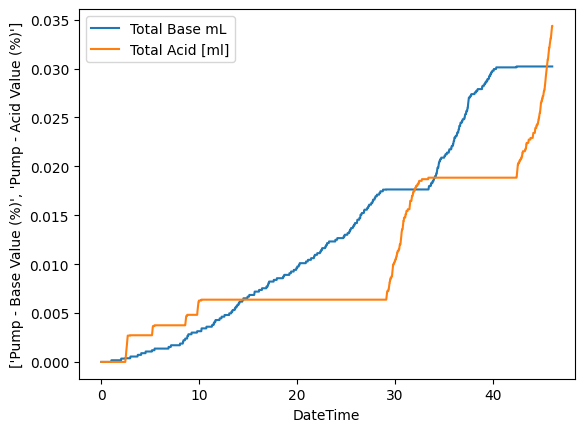

In [22]:
fig, ax = plt.subplots()

ax.plot(df_included['time [h]'], df_included[['cum. base feed [ml/min]', 'cum. acid feed [ml/min]']], label=['Total Base mL', 'Total Acid [ml]'])

ax.set_xlabel('DateTime')
ax.set_ylabel(['Pump - Base Value (%)', 'Pump - Acid Value (%)'])
ax.legend()
plt.show()

In [23]:
df_included.shape

(2767, 21)